# Project: 한국어 데이터로 챗봇 만들기
- Transformer
- Chatbot

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

## 1. Load Data

In [2]:
data = pd.read_csv("./data/ChatbotData.csv")
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
len(data)

11823

## 2. Data Preprocessing

In [4]:
def preprocessing(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣ㄱ-ㅎa-zA-Z0-9?.!,]+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [5]:
# 확인
for i in range(10):
    print(preprocessing(data.Q[i]))

12시 땡 !
1지망 학교 떨어졌어
3박4일 놀러가고 싶다
3박4일 정도 놀러가고 싶다
PPL 심하네
SD카드 망가졌어
SD카드 안돼
SNS 맞팔 왜 안하지
SNS 시간낭비인 거 아는데 매일 하는 중
SNS 시간낭비인데 자꾸 보게됨


In [6]:
questions = data["Q"].apply(lambda x: preprocessing(x)).values
answers = data["A"].apply(lambda x: preprocessing(x)).values

## 3. Tokenizing

### 1) Set Tokenizer

In [7]:
# train 데이터에 대해 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions+answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8358]
END_TOKEN의 번호 : [8359]


In [8]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8360


### 2) Set Max Length

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 16
텍스트의 평균 길이 : 3.938509684513237
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 24
헤드라인의 평균 길이 : 4.716146494121627


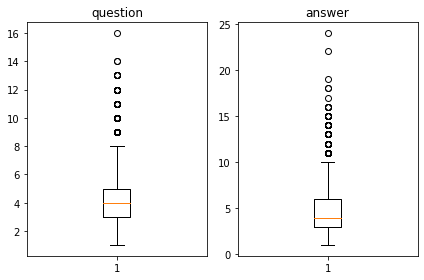

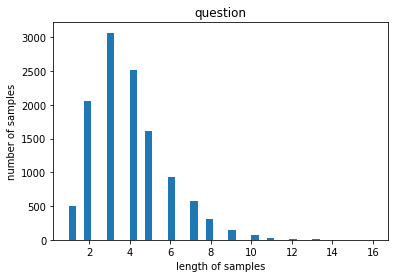

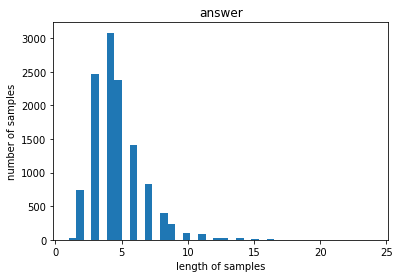

In [9]:
# 길이 분포 출력
question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print('텍스트의 최소 길이 : {}'.format(np.min(question_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(question_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(question_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(answer_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(answer_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(answer_len)))

plt.subplot(1,2,1)
plt.boxplot(question_len)
plt.title('question')
plt.subplot(1,2,2)
plt.boxplot(answer_len)
plt.title('answer')
plt.tight_layout()
plt.show()

plt.title('question')
plt.hist(question_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answer')
plt.hist(answer_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [10]:
MAX_LENGTH = 10

In [11]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [12]:
below_threshold_len(MAX_LENGTH, questions)
below_threshold_len(MAX_LENGTH,  answers)

전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.9956017931151147
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.9853675040175929


### 3) Tokenizing and Padding

In [13]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [14]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8360
필터링 후의 질문 샘플 개수: 9107
필터링 후의 답변 샘플 개수: 9107


In [15]:
# 질문 답변 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인 구성
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
print("기존 sample: ", answers[0, :])
print("input sample: ", answers[0, :-1]) # 마지막 토큰 제거
print("output sample: ", answers[0, 1:]) # 시작 토큰 제거

기존 sample:  [8358 3846   72 8077    1 8359    0    0    0    0]
input sample:  [8358 3846   72 8077    1 8359    0    0    0]
output sample:  [3846   72 8077    1 8359    0    0    0    0]


## 4. Build Model

### 1) Positional Encoding

In [17]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 2) Scaled Dot Product Attention

In [18]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

### 3) Multi Head Attention

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### 4) Masking

In [20]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [21]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 5) Encoder

In [22]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [23]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 6) Decoder

In [24]:
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [25]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

 ### 7) Transformer

In [26]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 8) build model

In [59]:
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3194368     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 5. Train Model

### 1) Loss Function

In [28]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 2) Custom Learning Rate Scheduling

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

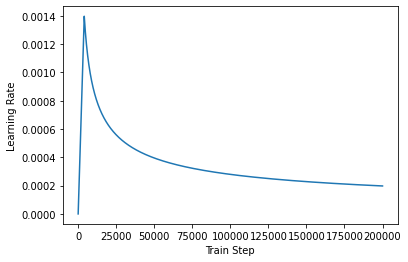

In [30]:
# example
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

plt.show()

### 3) Model Compile

In [60]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 4) Train

In [61]:
EPOCHS = 200
es = EarlyStopping(monitor='loss', patience=3, verbose=1)
history = model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[es])

Epoch 1/200
143/143 [==============================] - 9s 27ms/step - loss: 5.5939 - accuracy: 0.1097
Epoch 2/200
143/143 [==============================] - 4s 26ms/step - loss: 4.7112 - accuracy: 0.2051
Epoch 3/200
143/143 [==============================] - 4s 26ms/step - loss: 3.9078 - accuracy: 0.2155
Epoch 4/200
143/143 [==============================] - 4s 27ms/step - loss: 3.5058 - accuracy: 0.2209
Epoch 5/200
143/143 [==============================] - 4s 27ms/step - loss: 3.2873 - accuracy: 0.2318
Epoch 6/200
143/143 [==============================] - 4s 26ms/step - loss: 3.0964 - accuracy: 0.2429
Epoch 7/200
143/143 [==============================] - 4s 26ms/step - loss: 2.8975 - accuracy: 0.2583
Epoch 8/200
143/143 [==============================] - 4s 27ms/step - loss: 2.6781 - accuracy: 0.2809
Epoch 9/200
143/143 [==============================] - 4s 26ms/step - loss: 2.4431 - accuracy: 0.3085
Epoch 10/200
143/143 [==============================] - 4s 26ms/step - loss: 2.180

143/143 [==============================] - 4s 27ms/step - loss: 0.0091 - accuracy: 0.6645
Epoch 81/200
143/143 [==============================] - 4s 27ms/step - loss: 0.0087 - accuracy: 0.6644
Epoch 82/200
143/143 [==============================] - 4s 27ms/step - loss: 0.0086 - accuracy: 0.6646
Epoch 83/200
143/143 [==============================] - 4s 27ms/step - loss: 0.0084 - accuracy: 0.6644
Epoch 84/200
143/143 [==============================] - 4s 26ms/step - loss: 0.0090 - accuracy: 0.6643
Epoch 85/200
143/143 [==============================] - 4s 26ms/step - loss: 0.0077 - accuracy: 0.6646
Epoch 86/200
143/143 [==============================] - 4s 27ms/step - loss: 0.0090 - accuracy: 0.6644
Epoch 87/200
143/143 [==============================] - 4s 26ms/step - loss: 0.0080 - accuracy: 0.6646
Epoch 88/200
143/143 [==============================] - 4s 27ms/step - loss: 0.0072 - accuracy: 0.6648
Epoch 89/200
143/143 [==============================] - 4s 27ms/step - loss: 0.0080 - 

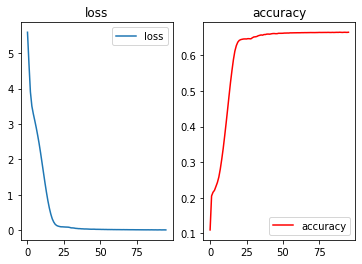

In [62]:
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['loss'], label='loss')
ax1.set_title("loss")
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history['accuracy'], label='accuracy', c="r")
ax2.set_title("accuracy")
ax2.legend()

plt.show()

## 6. Evaluate Model

In [34]:
def decoder_inference(sentence):
    sentence = preprocessing(sentence)

    # 입력된 문장을 정수 인코딩 후 시작 토큰과 종료 토큰을 앞뒤로 추가
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됨
        # 이 output_sequence는 다시 디코더의 입력이 됨
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [35]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받음
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [63]:
sentence_generation('안녕')

입력 : 안녕
출력 : 안녕하세요 .


'안녕하세요 .'

In [64]:
sentence_generation('뭐해?')

입력 : 뭐해?
출력 : 냉장고 파먹기 해보세요 .


'냉장고 파먹기 해보세요 .'

In [65]:
sentence_generation('넌 꿈이 뭐야?')

입력 : 넌 꿈이 뭐야?
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'

In [66]:
sentence_generation('너는 누구야?')

입력 : 너는 누구야?
출력 : 저는 마음을 이어주는 위로봇입니다 .


'저는 마음을 이어주는 위로봇입니다 .'

In [67]:
sentence_generation('오늘 밥 뭐 먹을까?')

입력 : 오늘 밥 뭐 먹을까?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [70]:
# 일부러 오타내보기
sentence_generation('오늘 모하까')

입력 : 오늘 모하까
출력 : 쓰지 않으면 모여요 .


'쓰지 않으면 모여요 .'

In [72]:
# 일부러 띄어쓰기 안해보기
sentence_generation('오늘뭐먹지')

입력 : 오늘뭐먹지
출력 : 나랑 같이 놀아요 .


'나랑 같이 놀아요 .'

In [73]:
# 띄어쓰기 제대로 한 경우
sentence_generation('오늘 뭐 먹지')

입력 : 오늘 뭐 먹지
출력 : 색다른걸 드셔보세요 .


'색다른걸 드셔보세요 .'

## 7. Experiments

### 1) 노드 파라미터 그대로 사용 (max_len=10)
+) epoch 200에 early stopping 적용
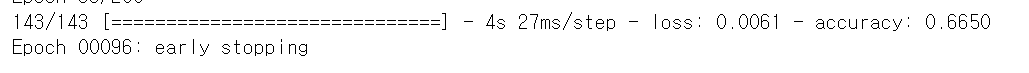
#### loss, accuracy 그래프
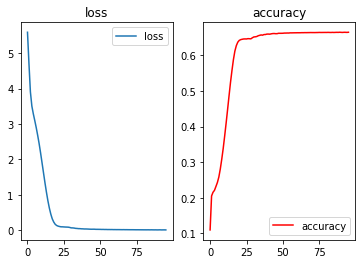
#### 테스트 결과
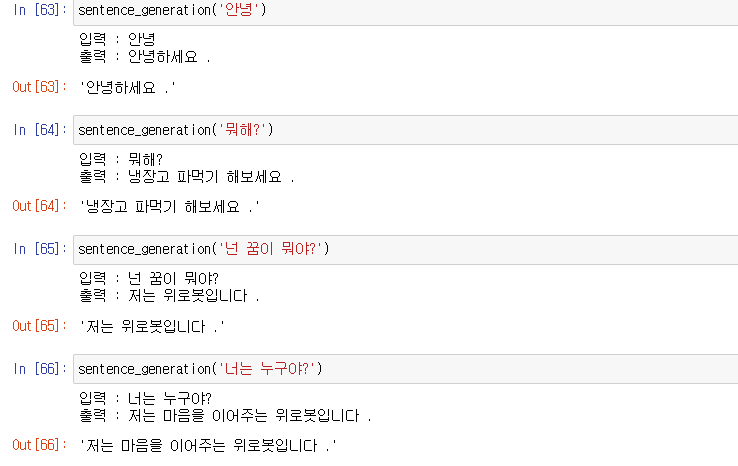

### 2) num_layers를 논문대로 6으로 변경 (max_len=10)
+) epoch 200에 early stopping 적용 <br>
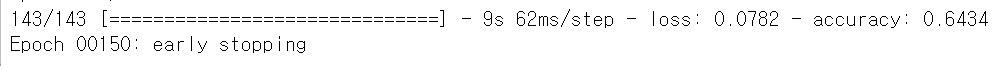
#### loss, accuracy 그래프
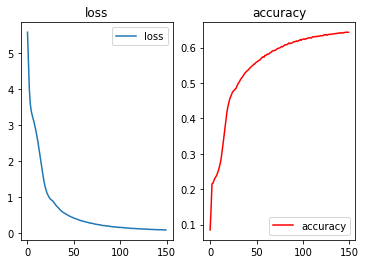
#### 테스트 결과
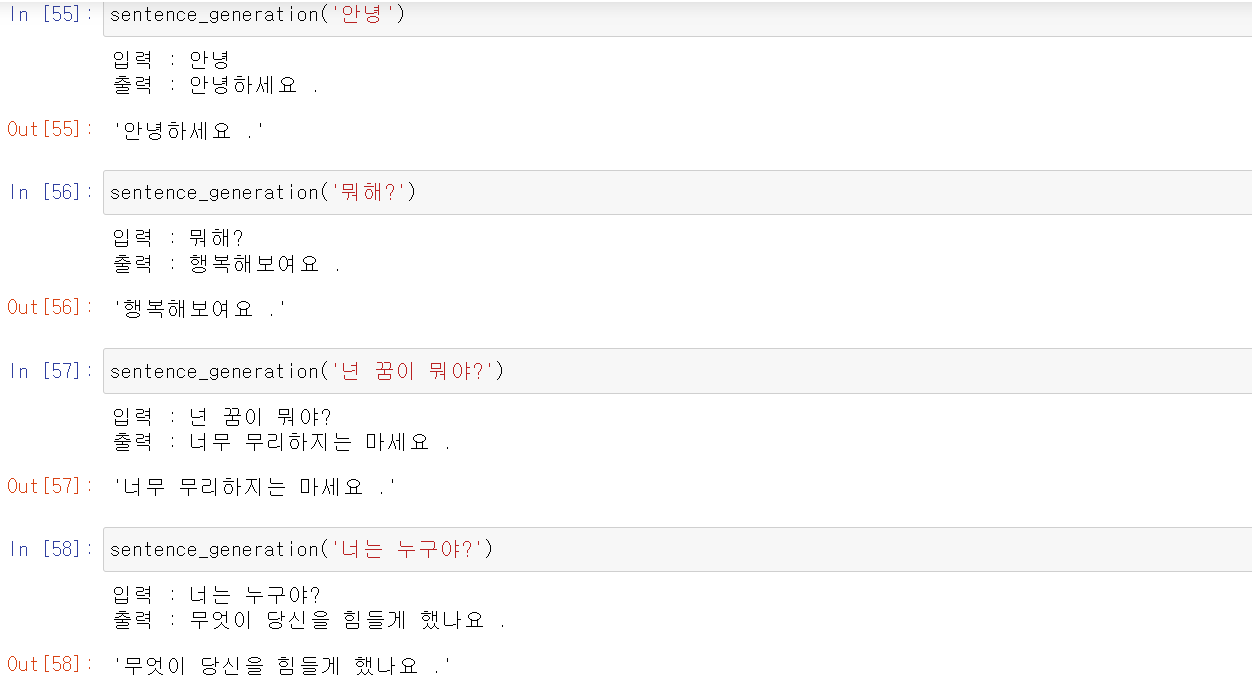

### 3) 논문대로 num_layers를 6으로, d_model을 512로, units를 2048로 (max_len=10)
+) epoch 200에 early stopping 적용
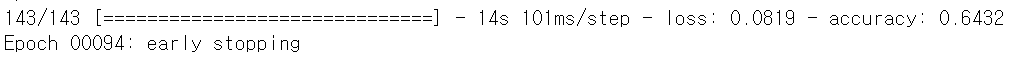
#### loss, accuracy 그래프
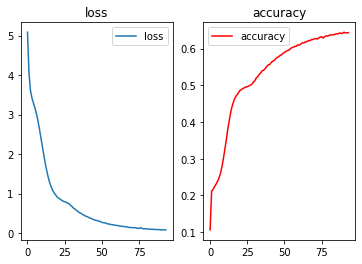
#### 테스트 결과
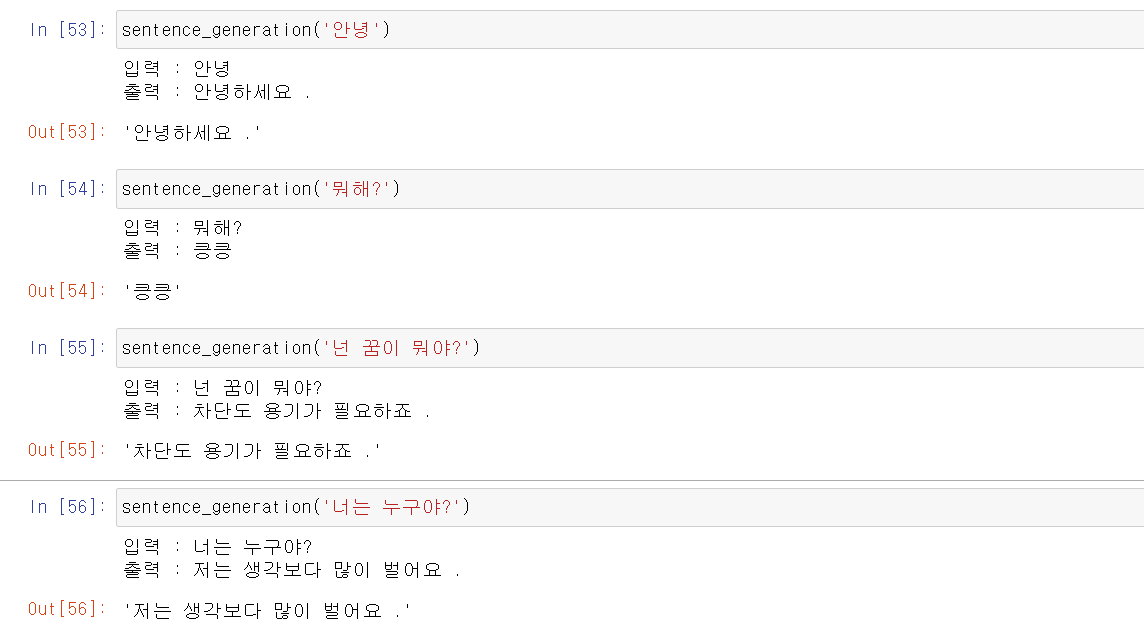

## 회고

- 데이터셋을 살펴봤을 때 숫자가 포함되어야 한다고 생각해서 숫자를 포함시켜서 전처리를 해줬다.
- 논문에 나온대로 하이퍼파라미터를 적용해봤을 때 오히려 결과가 안좋게 나왔다. 작은 데이터셋에 복잡한 모델을 적용해서 그런 것 같다고 생각한다.
- 모델이 비교적 단순한 첫 번째 실험에서 loss도 제일 낮고, 정확도는 제일 높고, 결과도 그럴싸하게 나왔다.
- 띄어쓰기가 잘못된 경우, 오타가 난 경우에는 질문을 잘 이해하지 못하는 것 같다.